In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
import os
import torch
import networks.torch_vgg as vgg
import torch.nn as nn
import numpy as np
import math
import copy
import matplotlib.pyplot as plt

In [3]:
from main import validate
from datasets import dataprep
from gsp_model import GSP_Model
from main import AverageMeter, accuracy


In [4]:
class Args:
    arch = 'vgg19_bn'
    dataset='cifar10'
    workers = 4
    epochs=160
    start_epoch=0
    batch_size = 128
    lr = 0.1
    momentum = 0.9
    weight_decay=1e-4
    print_freq = 50
    resume = False
    evaluate = False
    pretrained = False
    half = False
    exp_name = 'gsp_test'
    
    gpu=None
    logdir = '/logdir'
    gsp_training = True 
    gsp_sps = 0.8
    scheduled_sps_run = True
    proj_filters = False
    proj_model = False
    gsp_int = 150
    gsp_start_ep = -1
    finetune = False
    finetune_sps = 0.9
    
    filelogger = None

global args, best_acc1
args = Args

In [5]:
args.resume = "/private/home/riohib/explore/gsp_cifar/cifar/model_best.pth.tar"

In [6]:
# Load Model
if args.dataset == 'cifar10': num_classes = 10
if args.dataset == 'cifar100': num_classes = 100

if 'vgg' in args.arch: model = vgg.__dict__["vgg19_bn"](num_classes=num_classes)
model = torch.nn.DataParallel(model)

model.cuda()

train_loader, val_loader = dataprep.get_data_loaders(dataset=args.dataset, args=args)

Files already downloaded and verified


In [7]:
# model_gsp = GSP_Model(model)
# model_gsp.logger = args.filelogger # Initiate Logger
criterion = nn.CrossEntropyLoss().cuda()

optimizer = torch.optim.SGD(model.parameters(), args.lr,
                            momentum=args.momentum,
                            weight_decay=args.weight_decay)

In [8]:
# optionally resume from a checkpoint
chkpt_path = args.resume
def load_checkpoint(chkpt_path):
    checkpoint = torch.load(chkpt_path)
    args.start_epoch = checkpoint['epoch'] if not args.finetune else 0
    best_acc1 = checkpoint['best_acc1'] if not args.finetune else 0
    model.load_state_dict(checkpoint['state_dict'])

load_checkpoint(chkpt_path)


In [9]:
fft_model = copy.deepcopy(model)

In [10]:
validate(val_loader, model, criterion, args)


 Validation Acc@1: 93.090 



93.09

In [11]:
validate(val_loader, fft_model, criterion, args)


 Validation Acc@1: 93.090 



93.09

### Transforms

In [12]:
params_d = dict()
names = list()
for name, params in model.named_parameters():
    names.append(name)
    params_d[name] = params

In [13]:
param_fft = torch.fft.fftn(params_d[names[4]])

In [14]:
module_d = dict()
for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        module_d[name] = module.weight.data

In [15]:
weight_tensor = module_d[name].flatten()
numelem = weight_tensor.shape[0]
topk_weights = numelem * 0.1
print(topk_weights)

512.0


In [16]:
module_d[name].shape

torch.Size([10, 512])

In [17]:
def threshold_tensor(in_tensor, sparsity=0.9):
    t_shape = in_tensor.shape
    tensor = in_tensor.flatten()
    w_sps_num =  len(tensor) * sparsity
    sorted_weights, _ = torch.sort(tensor.abs())
    threshold = sorted_weights[:math.ceil(w_sps_num)+1][-1]
    sps_tensor = torch.where(abs(tensor) < threshold, torch.tensor(0.0, device=tensor.device), tensor)
    out_tensor = sps_tensor.reshape(t_shape)
    return out_tensor

def get_mask(in_tensor, sparsity=0.9):
    out_tensor = threshold_tensor(in_tensor, sparsity=sparsity)
    mask = out_tensor > 0.0   
    return mask 

In [18]:
# def model_fft_ifft(model):
fft_module = dict()
ifft_module = dict()
sps_fft = dict()
sps_abs_fft = dict()
sps = 0.8

for name, module in model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        fft_module[name] = torch.fft.fft(module.weight.data) # apply FFT
        sps_abs_fft[name] = torch.abs(fft_module[name]) # get absolute FFT vales (make real)
        sps_mask = get_mask(sps_abs_fft[name], sparsity=sps) # use the normalized real values for getting the topk mask
        sps_fft_tensor = fft_module[name] * sps_mask # but mask the actual complex FFT values topk
        ifft_module[name] = torch.fft.ifft(sps_fft_tensor).real # IFFT the sparse complex topk and save only the real values


In [19]:
for name, module in fft_model.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        module.weight.data = ifft_module[name]

In [20]:
model.module.classifier[0].weight.data

tensor([[ 6.1433e-03,  2.6787e-03,  8.7375e-03,  ..., -7.8123e-03,
          1.2930e-02, -8.0516e-03],
        [ 1.6031e-03, -1.8802e-03, -2.0471e-03,  ..., -1.6106e-03,
         -1.5061e-03, -7.2228e-04],
        [-1.6352e-03, -2.9582e-03,  4.8631e-04,  ...,  3.9759e-03,
         -5.9812e-03,  1.5399e-02],
        ...,
        [ 3.8525e-03, -2.2186e-03,  8.3077e-03,  ...,  1.6121e-04,
          4.8145e-04,  3.8776e-03],
        [-1.0152e-03, -1.0338e-03,  1.7625e-04,  ...,  5.7871e-04,
         -2.7955e-04, -1.6501e-05],
        [-6.7887e-04,  2.7948e-04, -2.5118e-04,  ..., -1.1105e-03,
          2.9323e-05, -4.7149e-04]], device='cuda:0')

In [21]:
fft_model.module.classifier[0].weight.data

tensor([[ 0.0038,  0.0017,  0.0071,  ..., -0.0071,  0.0140, -0.0092],
        [-0.0012, -0.0012, -0.0012,  ..., -0.0012, -0.0012, -0.0012],
        [-0.0010, -0.0053, -0.0009,  ...,  0.0063, -0.0040,  0.0129],
        ...,
        [-0.0009,  0.0022,  0.0028,  ...,  0.0021,  0.0016,  0.0023],
        [-0.0003, -0.0003, -0.0003,  ..., -0.0003, -0.0003, -0.0003],
        [-0.0007, -0.0007, -0.0007,  ..., -0.0007, -0.0007, -0.0007]],
       device='cuda:0')

In [22]:
validate(val_loader, fft_model, criterion, args)


 Validation Acc@1: 21.290 



21.29

In [23]:
validate(val_loader, model, criterion, args)


 Validation Acc@1: 93.090 



93.09

### Model Step Class

In [5]:
if 'vgg' in args.arch: model = vgg.__dict__["vgg19_bn"](num_classes=10)
model = torch.nn.DataParallel(model)
model.cuda()

DataParallel(
  (module): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): ReLU(inplace=True)
      (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): ReLU(inplace=True)
      (13): MaxPool2d(kernel_size=2, stride=2, padding=0

In [6]:
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), args.lr, momentum=args.momentum, weight_decay=args.weight_decay)
train_loader, val_loader = dataprep.get_data_loaders(dataset=args.dataset, args=args)

Files already downloaded and verified


In [7]:
from analysis import ModelAnalysis

In [8]:
exp = ModelAnalysis(model, optimizer, criterion, train_loader, val_loader)

In [9]:
exp.validate()


 Validation Acc@1: 10.410 



10.41

In [10]:
exp.train_mode()

Setting to train mode


In [32]:
data, label = exp.sample_data()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


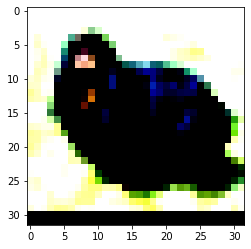

In [33]:
image = data[0].cpu()
plt.imshow(image.permute(1, 2, 0))

In [61]:
for i in range(100):
    loss = exp.sample_forward()
    print(loss)
    exp.backward(loss)
    exp.step()

tensor(2.6577, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.9993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6599, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.2582, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3164, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.3020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1849, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5815, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0227, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.1684, device='cuda:0', grad_fn=

In [38]:
for i in range(380):
    loss = exp.iterate_once()
    print(f"[{i}] loss: {loss}")

loss: 1.417341947555542
loss: 1.4897992610931396
loss: 1.426558256149292
loss: 1.384011149406433
loss: 1.2290867567062378
loss: 1.4038232564926147
loss: 1.1557608842849731
loss: 1.4139248132705688
loss: 1.3632365465164185
loss: 1.281136393547058
loss: 1.4151335954666138
loss: 1.321130633354187
loss: 1.2081305980682373
loss: 1.2663841247558594
loss: 1.3112428188323975
loss: 1.3415957689285278
loss: 1.2595980167388916
loss: 1.3191004991531372
loss: 1.2523534297943115
loss: 1.431586503982544
loss: 1.3386732339859009
loss: 1.0498543977737427
loss: 1.2873094081878662
loss: 1.2072346210479736
loss: 1.4247164726257324
loss: 1.33183753490448
loss: 1.201865792274475
loss: 1.1732171773910522
loss: 1.305959701538086
loss: 1.354562520980835
loss: 1.3651447296142578
loss: 1.275765299797058
loss: 1.261001467704773
loss: 1.3239446878433228
loss: 1.436183214187622
loss: 1.36508309841156
loss: 1.456154704093933
loss: 1.344873309135437
loss: 1.3187092542648315
loss: 1.4195979833602905
loss: 1.4675192832

In [35]:
for i in range(5):
    exp.train_epoch()

Training: batch_id:[0] | Acc@1: 26.56 | Loss: 1.938923954963684
Training: batch_id:[20] | Acc@1: 21.54 | Loss: 2.0795178413391113
Training: batch_id:[40] | Acc@1: 21.49 | Loss: 2.0643038749694824
Training: batch_id:[60] | Acc@1: 21.54 | Loss: 1.9637987613677979
Training: batch_id:[80] | Acc@1: 21.65 | Loss: 2.0018930435180664
Training: batch_id:[100] | Acc@1: 22.06 | Loss: 1.9809231758117676
Training: batch_id:[120] | Acc@1: 22.31 | Loss: 2.1040079593658447
Training: batch_id:[140] | Acc@1: 22.41 | Loss: 2.0015015602111816
Training: batch_id:[160] | Acc@1: 22.67 | Loss: 1.907214641571045
Training: batch_id:[180] | Acc@1: 22.78 | Loss: 1.997668981552124
Training: batch_id:[200] | Acc@1: 22.97 | Loss: 1.9010010957717896
Training: batch_id:[220] | Acc@1: 23.14 | Loss: 1.9728494882583618
Training: batch_id:[240] | Acc@1: 23.18 | Loss: 1.971200942993164
Training: batch_id:[260] | Acc@1: 23.34 | Loss: 2.035740852355957
Training: batch_id:[280] | Acc@1: 23.55 | Loss: 1.8482301235198975
Traini

In [333]:
loss = exp.sample_forward()
print(loss)
exp.backward(loss)
exp.step()

tensor(3.5723, device='cuda:0', grad_fn=<NllLossBackward0>)


TypeError: backward() missing 1 required positional argument: 'loss'

In [310]:
for i in range(100):
    exp.iterate_once()

Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to train mode
Setting to

In [320]:
params_d = dict()
for name, params in exp.model.named_parameters():
    params_d[name] = params

In [321]:
params_d

{'module.features.0.weight': Parameter containing:
 tensor([[[[ 0.1759, -0.0015,  0.0382],
           [-0.0113,  0.0736, -0.0569],
           [ 0.0417,  0.0545, -0.0611]],
 
          [[-0.0418, -0.0942, -0.0136],
           [ 0.1758, -0.0062,  0.0290],
           [ 0.0151,  0.0022,  0.0441]],
 
          [[ 0.0153, -0.0438,  0.0523],
           [ 0.0268, -0.0200,  0.0332],
           [ 0.0451,  0.0590, -0.0263]]],
 
 
         [[[ 0.0064, -0.0202,  0.0373],
           [-0.0789, -0.1407,  0.0120],
           [ 0.0401,  0.0815,  0.0572]],
 
          [[ 0.1374,  0.0087, -0.0596],
           [ 0.0080, -0.0809, -0.2124],
           [-0.0584,  0.0580, -0.0757]],
 
          [[-0.1096, -0.0294,  0.0258],
           [ 0.0101, -0.0099,  0.0276],
           [-0.0332,  0.0481,  0.0646]]],
 
 
         [[[ 0.0080,  0.0292,  0.0222],
           [-0.0299, -0.0185, -0.1320],
           [ 0.0155,  0.0494,  0.0325]],
 
          [[ 0.0109, -0.0619, -0.0642],
           [-0.0409,  0.0621, -0.0045],
  

In [288]:
validate(val_loader, model, criterion, args)


 Validation Acc@1: 29.608 



29.608386075949365

In [244]:
for i, (input, target) in enumerate(train_loader):
    target = target.cuda()
    input_var = input.cuda()
    target_var = target

    # compute output
    output = model(input_var)
    loss = criterion(output, target_var)

    # compute gradient and do SGD step
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    output = output.float()
    loss = loss.float()
    # measure accuracy and record loss
    prec1 = accuracy(output.data, target)[0]
    losses.update(loss.item(), input.size(0))
    top1.update(prec1.item(), input.size(0))